# **Waze Project**


### **Imports and data loading**

In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

# Feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle 

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspecting first five rows
df0.head(5)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## **PACE: Analyze**

### **Feature engineering**

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Create 'km_per_driving_day' that represents the mean number of kilometers driven on each driving day in the last month for each user

In [6]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Get descriptive stats
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,inf
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,NaN
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,3.022063e+00
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,1.672804e+02
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,3.231459e+02
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,7.579257e+02
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,inf


Some of the values are infinite, so we will replace them with 0

In [7]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

Create `percent_sessions_in_last_month` column that represents the percentage of each user's total sessions that were logged in their last month of use.

In [8]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions']/df['total_sessions']

# Get descriptive stats
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,578.963113,0.449255
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,1030.094384,0.286919
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15420.234110,1.530637


Create `professional_driver` column. A '1' means the user had 60 or more drives and drove on 15+ days last month

In [9]:
# Create `professional_driver` feature.
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1,0)

Create `total_sessions_per_day` column. Represents the mean number of sessions per day since onboarding

In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']

In [11]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

Create 'km_per_hour column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature

df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

Create km_per_drive column representing the mean number of kilometers per drive made in the last month for each user.

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

Convert the infinite values to 0

In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

Create 'percent_pf_sessions_to_favorite column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. 
This is a representation for the percent of overall drives that are to a favorite place.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] =  (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### **Check/Drop missing values**

In [17]:
# Check for missing values
df.isna().sum()

ID                                   0
label                              700
sessions                             0
drives                               0
total_sessions                       0
n_days_after_onboarding              0
total_navigations_fav1               0
total_navigations_fav2               0
driven_km_drives                     0
duration_minutes_drives              0
activity_days                        0
driving_days                         0
device                               0
km_per_driving_day                   0
percent_sessions_in_last_month       0
professional_driver                  0
total_sessions_per_day               0
km_per_hour                          0
km_per_drive                         0
percent_of_sessions_to_favorite      0
dtype: int64

In [18]:
# Drop rows with missing values
df = df.dropna(axis=0)

df.isna().sum()

ID                                 0
label                              0
sessions                           0
drives                             0
total_sessions                     0
n_days_after_onboarding            0
total_navigations_fav1             0
total_navigations_fav2             0
driven_km_drives                   0
duration_minutes_drives            0
activity_days                      0
driving_days                       0
device                             0
km_per_driving_day                 0
percent_sessions_in_last_month     0
professional_driver                0
total_sessions_per_day             0
km_per_hour                        0
km_per_drive                       0
percent_of_sessions_to_favorite    0
dtype: int64

### **Outliers**

Looking at the descriptive stats we can see that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable encoding**

#### **Dummying features**
Create a new, binary column called 'device2' that encodes user devices as follows:

* 'Android' -> '0'
* 'iPhone' -> '1'

In [19]:
# Create new `device2` variable
df['device2'] = df['device'].replace({'Android' : 0, 'iPhone': 1})
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target encoding**
Create a new, binary column called 'label2' that encodes user label as either 'churned or 'retained as follows:

* 'retained' -> '0'
* 'churned' -> '1'

In [20]:
# Create binary `label2` column

df['label2'] = df['label'].replace({'retained': 0, 'churned':1})

df[['label','label2']].tail(5)

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature selection**

The only column that will be droped for now is 'ID, since it doesn't contain any information relevant to churn.

In [21]:
# Drop `ID` column
df = df.drop(columns= ['ID'], axis =1)

### **Evaluation metric**
First, examine the class balance of the target variable.

In [22]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)*100

label
retained    82.264494
churned     17.735506
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

The risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. So we will select the best model based on recall score. The recall metric tells us what proportion of true positives was identified correctly.

## **Construct**

### **Split the data**

Now we willsplit the data into features/target variable and training/validation/test sets.

We will split the data 80/20 into a training set and a test set. 

Then we will split the training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets.

In [23]:
# 1. Isolate X variables

X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable

y = df['label2']

# 3. Split into train and test sets

X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [24]:
X_tr.shape, X_val.shape, X_test.shape, y_tr.shape, y_val.shape, y_test.shape

((11439, 18), (2860, 18), (2860, 18), (11439,), (2860,), (2860,))

### **Modeling**

#### **Random forest**

The hyperparameters we will tune are 

 - 'max_depth'
 - 'max_features'
 - 'max_samples'
 - 'min_samples_leaf'
 - 'min_samples_split'
 - 'n_estimators'


In [25]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }


# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV( rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [26]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 15.4 ms, total: 1min 57s
Wall time: 1min 57s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'precision', 'recall', 'accuracy'})

Examine the best average score across all the validation folds.

In [27]:
# Examine best score
rf_cv.best_score_

0.12678201409034398

Examine the best combination of hyperparameters.

In [28]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [29]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict ={'precision' : 'mean_test_precision',
               'recall': 'mean_test_recall',
               'f1': 'mean_test_f1',
               'accuracy': 'mean_test_accuracy'}

  # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    

  # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )
    
    return table 


In [30]:
results = make_results('RF CV', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.457163,0.126782,0.198445,0.81851


Asside from the accuracy, the scores aren't that good. We will now build a XGBoost model to see if the score will improve.

#### **XGBoost**

The hyperparameters we will tune are: 

 - 'max_depth'
 - 'min_child_weight'
 - 'learning_rate'
 - 'n_estimators'


In [31]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = 'accuracy', 'precision', 'recall', 'f1'

# 4. Instantiate the GridSearchCV object
xgb_cv =GridSearchCV(xgb, cv_params, scoring= scoring, refit='recall')

Now fit the model to the training data

In [32]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 5min 39s, sys: 2.35 s, total: 5min 41s
Wall time: 2min 53s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=('accuracy', 'precision', 'recall', 'f1'))

Get the best score from this model.

In [33]:
# Examine best score
xgb_cv.best_score_

0.172141932700604

And the best parameters.

In [34]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [35]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB CV', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.457163,0.126782,0.198445,0.81851
0,XGB CV,0.441004,0.172142,0.247245,0.81443


This model fit the data even better than the random forest model.

### **Model selection**

Now, we will use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [36]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [37]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [38]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.457163,0.126782,0.198445,0.818510
0,XGB CV,0.441004,0.172142,0.247245,0.814430
0,RF val,0.445255,0.120316,0.189441,0.817483


We see that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Get the performance scores of the XGBoost model on the validation data.

In [39]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.457163,0.126782,0.198445,0.818510
0,XGB CV,0.441004,0.172142,0.247245,0.814430
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.408451,0.171598,0.241667,0.809091


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

## **Execute**

### **Use champion/winning model to predict on test data**

Now, use the winning model to predict on the test dataset. This will give us the final indication of how we should expect the model to perform on new future data.

In [40]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.457163,0.126782,0.198445,0.818510
0,XGB CV,0.441004,0.172142,0.247245,0.814430
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.408451,0.171598,0.241667,0.809091
0,XGB test,0.413043,0.187377,0.257802,0.808741


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

Plot a confusion matrix of the champion/winning model's predictions on the test data.

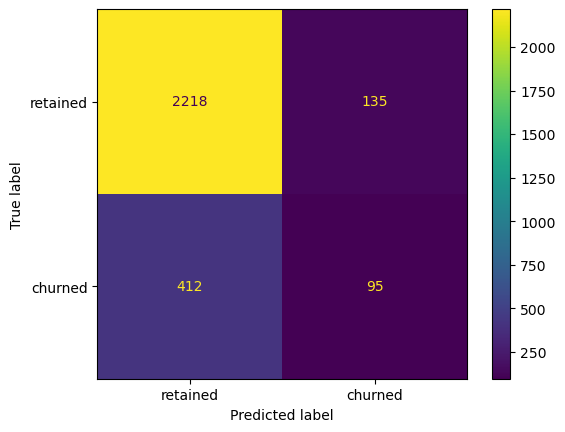

In [41]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

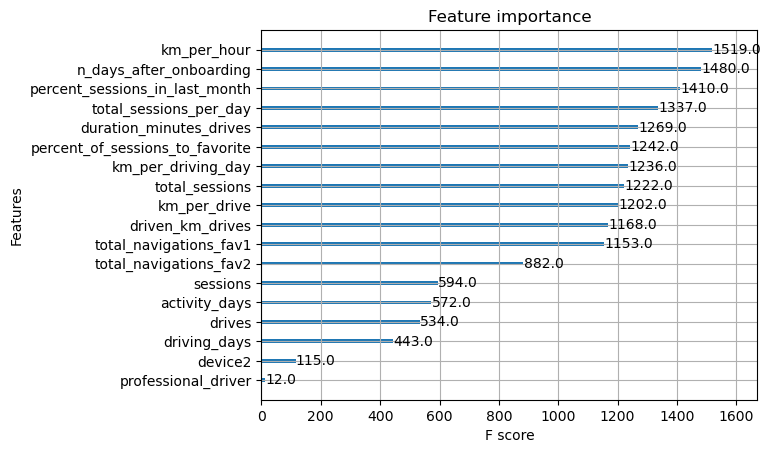

In [42]:
plot_importance(xgb_cv.best_estimator_)

### **Conclusion**

This model is not a good predictor for user churn. Due to the fact that its recall score is 17%. Since we know that 7 out of the top 10 important features were engineered, we could reconstruct the model and try different combinations of predictive features to help reduce the noise from unpredictive variables. It can be recommended that we gather more data that shows how users specifically interact with the app. Such as does a user report/confirm accidents or road hazards.